<a href="https://colab.research.google.com/github/couedrao/COVID_19_SIR_Model_Estimation/blob/master/COVID_19_SIR_Model_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\beta$ and $\gamma$ by Modeling :

> In [Novel coronavirus 2019-nCoV: early estimation of epidemiological parameters and epidemic predictions](https://www.medrxiv.org/content/10.1101/2020.01.23.20018549v2.full.pdf)

> In [A conceptual model for the coronavirus disease 2019 (COVID-19) outbreak in Wuhan, China with individual reaction and governmental action](https://www.ijidonline.com/article/S1201-9712(20)30117-X/fulltext)




# $\beta$ and $\gamma$ by Estimation from previous data as in this [WHO paper](https://www.who.int/bulletin/online_first/20-255158.pdf)

> \begin{align}
& \frac{dS}{dt} = - \frac{\beta I S}{N}, \\[6pt]
& \frac{dI}{dt} = \frac{\beta I S}{N}- \gamma I, \\[6pt]
& \frac{dR}{dt} = \gamma I,
\end{align} where <math>S</math> is the stock of susceptible population, <math>I</math> is the stock of infected, <math>R</math> is the stock of recovered population, <math>N</math> is the sum of these three, $\beta$ is the infection rate of covid19, and $\gamma$ is the recovery rate.

> What we are going to do is estimate the β and γ to fit the SIR model with the actual confirmed cases (the number of infectious people). To solve the ordinary differential equation like the SIR model, we can use solve_ivp function in scipy module.


Code source based on [1] (https://github.com/Lewuathe/COVID19-SIR)


In [0]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import sys
import json
import ssl
import urllib.request

In [0]:
! mkdir data 
%cd data
! wget https://raw.githubusercontent.com/Lewuathe/COVID19-SIR/master/data_url.json

/content/data
--2020-03-31 19:44:42--  https://raw.githubusercontent.com/Lewuathe/COVID19-SIR/master/data_url.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589 [text/plain]
Saving to: ‘data_url.json’

data_url.json       100%[===================>]     589  --.-KB/s    in 0s      

2020-03-31 19:44:47 (153 MB/s) - ‘data_url.json’ saved [589/589]



In [0]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('time_series_19-covid-Confirmed-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('time_series_19-covid-Recovered-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('time_series_19-covid-Deaths-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values
    
    
    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

    # Find $\beta$ and $\gamma$
    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        #print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")


In [0]:
def remove_province(input_file, output_file):
    input = open(input_file, "r")
    output = open(output_file, "w")
    output.write(input.readline())
    for line in input:
        if line.lstrip().startswith(","):
            output.write(line)
    input.close()
    output.close()
  

def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], url_title)


def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

country=France, beta=0.00000073, gamma=0.00000015, r_0:4.89027591


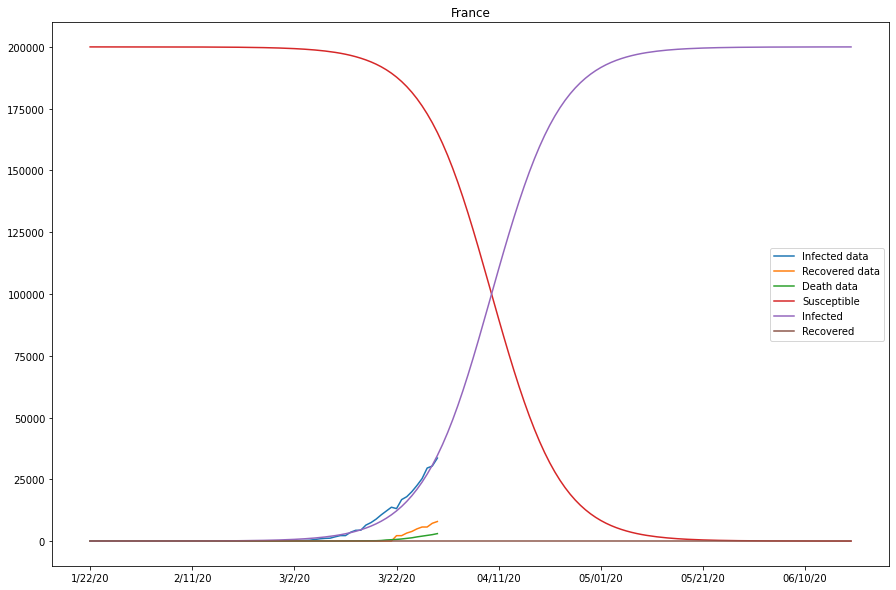

In [0]:
def main():

    countries=["France"]#, "US", "Venezuela"]
    download=True
    startdate="1/22/20"
    predict_range=150
    s_0=200000
    i_0 = 2
    r_0 = 10

    if download:
        data_d = load_json("data_url.json")
        download_data(data_d)

    remove_province('time_series_19-covid-Confirmed.csv', 'time_series_19-covid-Confirmed-country.csv')
    remove_province('time_series_19-covid-Recovered.csv', 'time_series_19-covid-Recovered-country.csv')
    remove_province('time_series_19-covid-Deaths.csv', 'time_series_19-covid-Deaths-country.csv')

    for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        learner.train()   

if __name__ == '__main__':
    main()